In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython.display import display
from ast import literal_eval
import pandas as pd

In [2]:
plt.rcParams['figure.figsize'] = (16, 9)

# ======================================================================
# 1. Load data from Excel
# ======================================================================
df = pd.read_excel('../data/df_dimensions.xlsx', index_col=0)


# Ensure 'year' exists and is numeric
if 'year' not in df.columns:
    raise ValueError("'year' column not found in the dataset.")
df['year'] = pd.to_numeric(df['year'], errors='coerce')

In [3]:
def split_list_field(value):

    if pd.isna(value):
        return []
    s = str(value)

    # Try to parse as Python literal list
    try:
        parsed = literal_eval(s)
        if isinstance(parsed, (list, tuple)):
            return [str(x).strip() for x in parsed if str(x).strip()]
    except Exception:
        pass

    # Fallback: split on common delimiters
    for sep in [';', '|']:
        if sep in s:
            return [x.strip() for x in s.split(sep) if x.strip()]

    # Last resort: single value
    s = s.strip()
    return [s] if s else []

In [4]:
# ======================================================================
# 1. Tables only (no figures)
# ======================================================================

# --- Countries exploded table ---
countries_df = (
    df[['id', 'year', 'research_org_country_names']]
    .assign(country_list=lambda d: d['research_org_country_names'].apply(split_list_field))
    .explode('country_list')
    .rename(columns={'country_list': 'country'})
)

countries_df = countries_df.dropna(subset=['country', 'year'])
countries_df['year'] = countries_df['year'].astype(int)

print("\nExploded (paper, year, country) table:")
display(countries_df.head())


# --- Country-level counts ---
country_counts = (
    countries_df
    .groupby('country')
    .agg(n_pubs=('id', 'nunique'))
    .reset_index()
    .sort_values('n_pubs', ascending=False)
)

print("\nTop countries by number of UKBB publications:")
display(country_counts.head(10))


# --- Institution-level counts (table only) ---
if 'research_org_names' in df.columns:
    orgs_df = (
        df[['id', 'year', 'research_org_names']]
        .assign(org_list=lambda d: d['research_org_names'].apply(split_list_field))
        .explode('org_list')
        .rename(columns={'org_list': 'org_name'})
    )

    orgs_df = orgs_df.dropna(subset=['org_name', 'year'])
    orgs_df['year'] = orgs_df['year'].astype(int)

    org_counts = (
        orgs_df.groupby('org_name')
        .agg(n_pubs=('id', 'nunique'))
        .reset_index()
        .sort_values('n_pubs', ascending=False)
    )

    print("\nTop institutions by number of UKBB publications:")
    display(org_counts.head(10))

else:
    print("\n'research_org_names' column not found — cannot print institution table.")



Exploded (paper, year, country) table:


,id,year,research_org_country_names,country
0,pub.1142697354,2021,"['China', 'Australia']",China
0,pub.1142697354,2021,"['China', 'Australia']",Australia
1,pub.1107515670,2018,"['United Kingdom', 'Norway']",United Kingdom
1,pub.1107515670,2018,"['United Kingdom', 'Norway']",Norway
2,pub.1111460082,2019,"['United States', 'United Kingdom']",United States



Top countries by number of UKBB publications:


,country,n_pubs
117,United States,4228
116,United Kingdom,4205
21,China,3666
3,Australia,1269
106,Sweden,955
39,Germany,944
75,Netherlands,942
19,Canada,722
28,Denmark,520
36,France,487



Top institutions by number of UKBB publications:


,org_name,n_pubs
3270,Harvard University,1162
7529,University of Oxford,967
607,Broad Institute,678
4670,Massachusetts General Hospital,652
7319,University of Cambridge,553
7193,University College London,532
4256,King's College London,529
593,Brigham and Womens Hospital Inc,500
4165,Karolinska Institutet,498
3655,Imperial College London,494


In [5]:

# ======================================================================
# 5. Choropleth map with GeoPandas
# ======================================================================

# Natural Earth 1:110m countries shapefile (public URL)
world_url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(world_url)

print("\nWorld shapefile example:")
display(world[['ADMIN', 'ISO_A3_EH']].head())

# Basic name harmonisation — extend as needed once you see mismatches

name_map = {
    'USA': 'United States of America',
    'US': 'United States of America',
    'United States': 'United States of America',
    'UK': 'United Kingdom',
    'Russia': 'Russian Federation',
    # Add more mappings as needed
}

country_counts['country_norm'] = country_counts['country'].replace(name_map)

world_counts = world.merge(
    country_counts,
    how='left',
    left_on='ADMIN',
    right_on='country_norm'
)

world_counts['n_pubs'] = world_counts['n_pubs'].fillna(0)


World shapefile example:


,ADMIN,ISO_A3_EH
0,Fiji,FJI
1,United Republic of Tanzania,TZA
2,Western Sahara,ESH
3,Canada,CAN
4,United States of America,USA


In [6]:
# ----------------------------------------------------------------------
# 3.1 Country-level counts for choropleth
# ----------------------------------------------------------------------
country_counts = (
    countries_df
    .groupby('country')
    .agg(n_pubs=('id', 'nunique'))
    .reset_index()
    .sort_values('n_pubs', ascending=False)
)

print("\nTop countries by number of UKBB publications:")
display(country_counts.head(10))

# ----------------------------------------------------------------------
# 3.2 Speed of uptake: cumulative count of distinct countries over time
# ----------------------------------------------------------------------
year_country = (
    countries_df[['year', 'country']]
    .drop_duplicates()
    .sort_values(['year', 'country'])
)

years = sorted(year_country['year'].unique())
cum_counts = []
seen = set()

for y in years:
    subset = year_country[year_country['year'] == y]['country']
    seen.update(subset)
    cum_counts.append({'year': y, 'cum_countries': len(seen)})

uptake_df = pd.DataFrame(cum_counts)


Top countries by number of UKBB publications:


,country,n_pubs
117,United States,4228
116,United Kingdom,4205
21,China,3666
3,Australia,1269
106,Sweden,955
39,Germany,944
75,Netherlands,942
19,Canada,722
28,Denmark,520
36,France,487


In [7]:

# ======================================================================
# 4. by institution
# ======================================================================
if 'research_org_names' in df.columns:
    orgs_df = (
        df[['id', 'year', 'research_org_names']]
        .assign(org_list=lambda d: d['research_org_names'].apply(split_list_field))
        .explode('org_list')
        .rename(columns={'org_list': 'org_name'})
    )

    orgs_df = orgs_df.dropna(subset=['org_name', 'year'])
    orgs_df['year'] = orgs_df['year'].astype(int)

    year_org = (
        orgs_df[['year', 'org_name']]
        .drop_duplicates()
        .sort_values(['year', 'org_name'])
    )

    years_org = sorted(year_org['year'].unique())
    cum_counts_org = []
    seen_orgs = set()

    for y in years_org:
        subset = year_org[year_org['year'] == y]['org_name']
        seen_orgs.update(subset)
        cum_counts_org.append({'year': y, 'cum_orgs': len(seen_orgs)})

    uptake_org_df = pd.DataFrame(cum_counts_org)
else:
    print("\n'research_org_names' column not found - skipping institution uptake analysis.")



/var/folders/04/q8s7l0r939g8fqqljjn3_rbm0000gn/T/ipykernel_7122/3526702937.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("cividis")


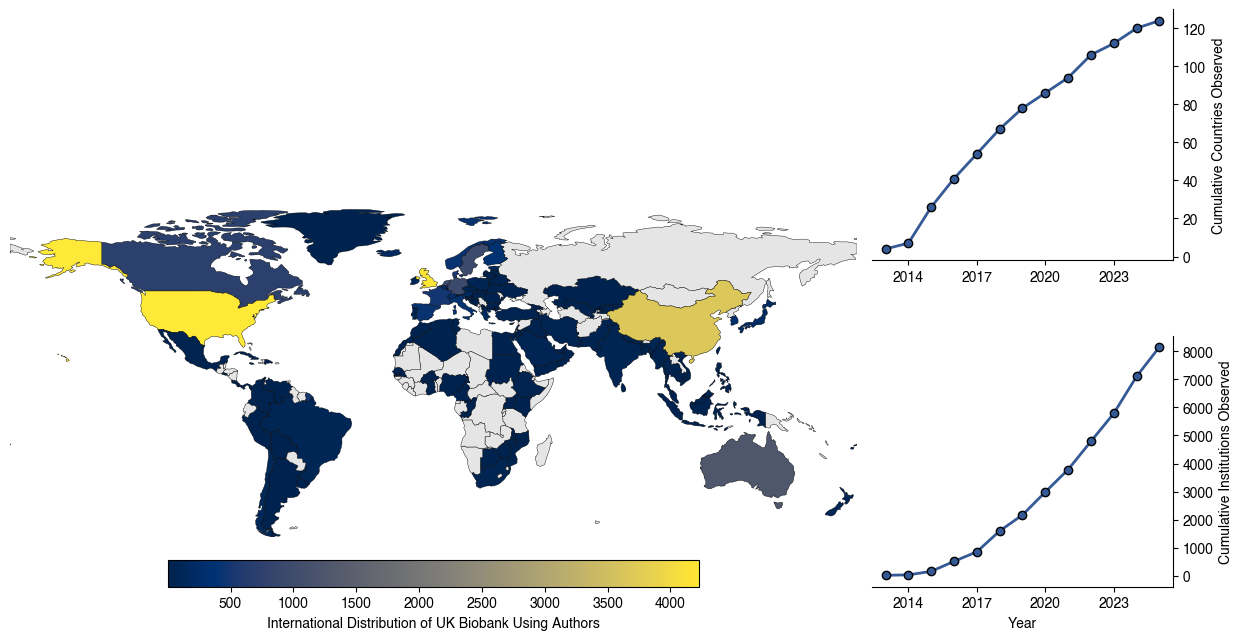

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MaxNLocator
import matplotlib.cm as cm
import matplotlib.colors as colors

plt.rcParams['font.family'] = 'Helvetica'

plt.close('all')

# ============================================================
# 1. Build viridis colours but force zeros to white
# ============================================================


world_counts = world_counts[world_counts["ADMIN"] != "Antarctica"]

# Normalise only over non-zero values
nonzero = world_counts.loc[world_counts['n_pubs'] > 0, 'n_pubs']
norm = colors.Normalize(vmin=nonzero.min(), vmax=nonzero.max())
cmap = cm.get_cmap("cividis")

# Base colours from viridis
viridis_colors = cmap(norm(world_counts['n_pubs']))

# Softer grey for zero values
ZERO_COLOR = "#E5E5E5"

color_array = []
for n, c in zip(world_counts['n_pubs'], viridis_colors):
    if n == 0:
        color_array.append(ZERO_COLOR)
    else:
        color_array.append(colors.to_hex(c))


# ============================================================
# 2. Figure layout
# ============================================================

fig = plt.figure(figsize=(16, 7.5))
gs = GridSpec(
    2, 4,
    figure=fig,
    width_ratios=[0.15, 4.5, 1.6, 0.1],
    height_ratios=[1, 1],
    wspace=0.05,
    hspace=0.3
)


# ============================================================
# 3. MAP PANEL — viridis continuous, zeros white
# ============================================================

ax_map = fig.add_subplot(gs[:, 1])

world_counts.plot(
    ax=ax_map,
    color=color_array,          # explicit colors
    linewidth=0.3,
    edgecolor="black",
    legend=False
)

ax_map.set_aspect('equal')  
#ax_map.set_title("International Distribution of UK Biobank Using Authors")
ax_map.margins(0)
ax_map.set_anchor('W')
ax_map.set_axis_off()
# move the legend to the central bottom
legend_bar = fig.colorbar(
    cm.ScalarMappable(
        cmap=cmap,
        norm=colors.Normalize(vmin=nonzero.min(), vmax=nonzero.max())
    ),
    ax=ax_map,
    orientation='horizontal',
    fraction=0.046,
    pad=0.04,
    #title="International Distribution of UK Biobank Using Authors"
)
legend_bar.set_label("International Distribution of UK Biobank Using Authors")


# ============================================================
# 4. Colourbar (continuous viridis, no white)
# ============================================================
'''
ax_cbar = fig.add_subplot(gs[:, 0])

sm = cm.ScalarMappable(
    cmap=cmap,
    norm=colors.Normalize(vmin=nonzero.min(), vmax=nonzero.max())
)
sm._A = []

cbar = fig.colorbar(sm, cax=ax_cbar, orientation='horizontal',
    fraction=0.046,
    pad=0.04,)
#cbar.ax.yaxis.set_ticks_position('left')
#cbar.ax.yaxis.set_label_position('left')
cbar.set_label("International Distribution of UK Biobank Using Authors", fontsize=12)

'''
# ============================================================
# 5. TOP RIGHT — cumulative countries
# ============================================================

ax1 = fig.add_subplot(gs[0, 2])
ax1.plot(uptake_df['year'], uptake_df['cum_countries'],
    marker='o', linewidth=2, markersize=6, markeredgecolor='k', markerfacecolor='#345995', color='#345995')

ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")
ax1.set_ylabel("Cumulative Countries Observed")

ax1.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax1.tick_params(axis='y', right=True, left=False)
ax1.tick_params(axis='x', bottom=True, top=False)

ax1.xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=5))
#ax1.grid(True, alpha=0.3)


# ============================================================
# 6. BOTTOM RIGHT — cumulative institutions
# ============================================================

ax2 = fig.add_subplot(gs[1, 2])

ax2.plot(uptake_org_df['year'], uptake_org_df['cum_orgs'],
    marker='o', linewidth=2, markersize=6, markeredgecolor='k', markerfacecolor='#345995', color='#345995')

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel("Cumulative Institutions Observed")
ax2.set_xlabel("Year")

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax2.tick_params(axis='y', right=True, left=False)
ax2.tick_params(axis='x', bottom=True, top=False)

ax2.xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=5))
#ax2.grid(True, alpha=0.2)

#ax1.set_title("Cumulative Countries Observed")
#ax2.set_title("Cumulative Institutions Observed")


# ============================================================
# 7. Spacer
# ============================================================

ax_blank = fig.add_subplot(gs[:, 3])
ax_blank.set_axis_off()
plt.savefig("../fig/geography/geography.pdf", bbox_inches='tight')
plt.savefig("../fig/geography/geography.svg", bbox_inches='tight')
plt.savefig("../fig/geography/geography.png", bbox_inches='tight', dpi=800)

## GIF 

In [9]:
countries_df

,id,year,research_org_country_names,country
0,pub.1142697354,2021,"['China', 'Australia']",China
0,pub.1142697354,2021,"['China', 'Australia']",Australia
1,pub.1107515670,2018,"['United Kingdom', 'Norway']",United Kingdom
1,pub.1107515670,2018,"['United Kingdom', 'Norway']",Norway
2,pub.1111460082,2019,"['United States', 'United Kingdom']",United States
...,...,...,...,...
10841,pub.1141330363,2021,"['United Kingdom', 'United States', 'Australia']",United States
10841,pub.1141330363,2021,"['United Kingdom', 'United States', 'Australia']",Australia
10842,pub.1137708373,2021,['United States'],United States
10843,pub.1130102784,2021,['United States'],United States


In [10]:
# ======================================================================
# 1. Tables for yearly map (no figures)
#   Output: world_counts_raw with columns: ADMIN, year, n_pubs
# ======================================================================

# --- Countries exploded table (paper, year, country) ---
countries_df = (
    df[['id', 'year', 'research_org_country_names']]
    .assign(country_list=lambda d: d['research_org_country_names'].apply(split_list_field))
    .explode('country_list')
    .rename(columns={'country_list': 'country'})
)

countries_df = countries_df.dropna(subset=['country', 'year'])
countries_df['year'] = countries_df['year'].astype(int)

# Optional: normalize country strings (helps joins to world geometries)
countries_df['country'] = (
    countries_df['country']
    .astype(str)
    .str.strip()
)

print("\nExploded (paper, year, country) table:")
display(countries_df.head())


# --- Yearly country-level counts (unique papers per country-year) ---
country_year_counts = (
    countries_df
    .groupby(['country', 'year'])
    .agg(n_pubs=('id', 'nunique'))
    .reset_index()
    .sort_values(['year', 'n_pubs'], ascending=[True, False])
)

print("\nExample: top countries in earliest year:")
display(country_year_counts[country_year_counts['year'] == country_year_counts['year'].min()].head(10))

country_year_counts['country_norm'] = country_year_counts['country'].replace(name_map)


# --- (Optional but useful) cumulative by country across years ---
# This yields cum_n_pubs per (country, year), which your GIF can use directly
country_year_cum = (
    country_year_counts
    .sort_values(['country', 'year'])
    .assign(cum_n_pubs=lambda d: d.groupby('country')['n_pubs'].cumsum())
)

print("\nCumulative example:")
display(country_year_cum.head(10))


# --- Make the exact long table expected by the animation code ---
# Use ADMIN to match typical Natural Earth naming (world['ADMIN'])
world_counts_raw = (
    country_year_counts
    .rename(columns={'country': 'ADMIN'})   # <-- join key for geometries
    [['ADMIN', 'year', 'n_pubs']]
)

print("\nworld_counts_raw (for yearly map/GIF):")
display(world_counts_raw.head(10))


Exploded (paper, year, country) table:


,id,year,research_org_country_names,country
0,pub.1142697354,2021,"['China', 'Australia']",China
0,pub.1142697354,2021,"['China', 'Australia']",Australia
1,pub.1107515670,2018,"['United Kingdom', 'Norway']",United Kingdom
1,pub.1107515670,2018,"['United Kingdom', 'Norway']",Norway
2,pub.1111460082,2019,"['United States', 'United Kingdom']",United States



Example: top countries in earliest year:


,country,year,n_pubs
660,United Kingdom,2013,4
403,Netherlands,2013,1
455,Pakistan,2013,1
673,United States,2013,1



Cumulative example:


,country,year,n_pubs,country_norm,cum_n_pubs
0,Algeria,2024,1,Algeria,1
1,Antigua and Barbuda,2023,1,Antigua and Barbuda,1
2,Argentina,2017,1,Argentina,1
3,Argentina,2019,1,Argentina,2
4,Argentina,2020,1,Argentina,3
5,Argentina,2021,1,Argentina,4
6,Argentina,2022,1,Argentina,5
7,Argentina,2023,1,Argentina,6
8,Argentina,2024,4,Argentina,10
9,Argentina,2025,6,Argentina,16



world_counts_raw (for yearly map/GIF):


,ADMIN,year,n_pubs
660,United Kingdom,2013,4
403,Netherlands,2013,1
455,Pakistan,2013,1
673,United States,2013,1
661,United Kingdom,2014,11
674,United States,2014,6
10,Australia,2014,2
404,Netherlands,2014,2
49,Belgium,2014,1
456,Pakistan,2014,1


In [11]:
from matplotlib import font_manager as fm
import matplotlib.patheffects as pe
helv_bold = fm.FontProperties(
    fname="/System/Library/Fonts/Helvetica.ttc",  # macOS
    weight="bold"
)

In [27]:
non_cumulating = False 

/var/folders/04/q8s7l0r939g8fqqljjn3_rbm0000gn/T/ipykernel_7122/3265216929.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap = cm.get_cmap("cividis")


GIF saved to: ../fig/geography/geography_yearly.gif


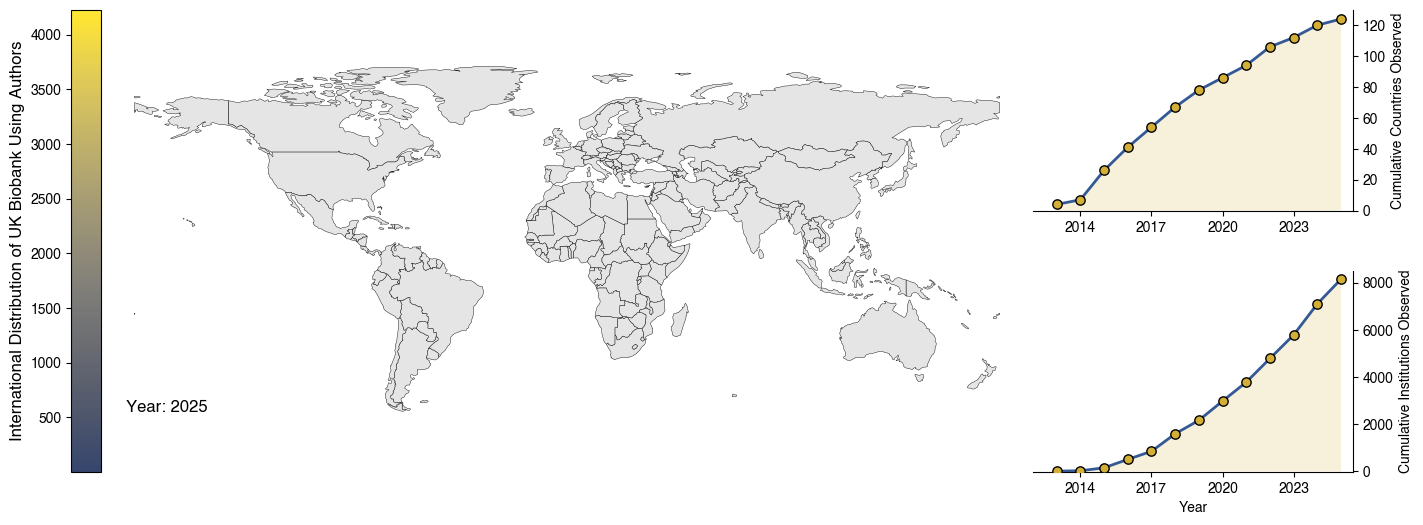

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MaxNLocator
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.animation import FuncAnimation, PillowWriter

#plt.rcParams['font.family'] = 'Helvetica'

# ---------- Parameters ----------
years = list(range(2013, 2026))          # 2013 .. 2025 inclusive
ZERO_COLOR = "#E5E5E5"
cmap_name = "cividis" #"cividis"
gif_path = f"../fig/geography/geography_yearly{'non_cumulating' if non_cumulating else ''}.gif"
fps = 0.5

# ---------- Prepare geometry source ----------
# Use your existing GeoDataFrame to provide geometry per country
# (This was called world_counts earlier; we'll extract unique geometries.)
world_geom = world_counts[['ADMIN', 'geometry']].drop_duplicates().set_index('ADMIN')

minx, miny, maxx, maxy = world_geom.geometry.total_bounds

# Crop off Antarctica (approx. south of -60 degrees)
ANTARCTICA_CUTOFF = -60  

pad_x = (maxx - minx) * 0.02
pad_y = (maxy - miny) * 0.02

xlim = (minx - pad_x, maxx + pad_x)
ylim = (ANTARCTICA_CUTOFF, maxy + pad_y)


world_counts_raw['ADMIN'] = world_counts_raw['ADMIN'].replace(name_map)

pivot = (
    world_counts_raw
    .groupby(['ADMIN', 'year'])['n_pubs'].sum()
    .unstack(fill_value=0)
)

# Ensure all years present in the pivot (add missing columns as 0)
for y in years:
    if y not in pivot.columns:
        pivot[y] = 0
pivot = pivot[sorted(pivot.columns)]

# Compute cumulative counts per country up to each year
cum_by_year = {}  # map year -> Series indexed by ADMIN
running = pd.DataFrame(index=pivot.index)
running = pivot.cumsum(axis=1)
for y in years:
    cum_by_year[y] = running[y].reindex(world_geom.index).fillna(0)  # align with geometry

# Global normalization: use global max of cumulative counts across all years (excluding zeros)
all_cums = pd.concat(cum_by_year.values())
global_nonzero = all_cums[all_cums > 0]
if len(global_nonzero):
    vmin = global_nonzero.min()
    vmax = global_nonzero.max()
else:
    vmin, vmax = 1, 1  # fallback to avoid division-by-zero

base_cmap = cm.get_cmap("cividis")

# Trim the darkest 20% of the colormap
cmap = colors.LinearSegmentedColormap.from_list(
    "cividis_trimmed",
    base_cmap(np.linspace(0.20, 1.0, 256))
)
    
norm = colors.Normalize(vmin=vmin, vmax=vmax)

# ---------- Build base figure and axes ----------
fig = plt.figure(figsize=(16, 6))
gs = GridSpec(
    2, 4,
    figure=fig,
    width_ratios=[0.15, 4.5, 1.6, 0.1],
    height_ratios=[1, 1],
    wspace=0.05,
    hspace=0.3
)

ax_cbar = fig.add_subplot(gs[:, 0])
ax_map = fig.add_subplot(gs[:, 1])
ax1 = fig.add_subplot(gs[0, 2])
ax2 = fig.add_subplot(gs[1, 2])
ax_blank = fig.add_subplot(gs[:, 3])
ax_blank.set_axis_off()

# -------------------------------------------------------------------
# Colour scheme & right-side plot styling
# -------------------------------------------------------------------
colors_scheme = ["#B80C09", "#D4AF37", "#6E8B3D", "#345995"]
line_color = colors_scheme[3]   # color of the line (blue as in screenshot)
fill_color = colors_scheme[1]   # color to fill the area under the curve (gold)
marker_fill = colors_scheme[1]  # marker face uses the gold fill color
marker_edge = "k"

xmin, xmax = 2012, 2025.5
ax1.set_xlim(xmin, xmax)
ax2.set_xlim(xmin, xmax)

# Configure right-side axes (formatting)
ax1.set_ylabel("Cumulative Countries Observed")
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")
ax1.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='y', right=True, left=False)
ax1.tick_params(axis='x', bottom=True, top=False)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=5))
ax1.set_ylim(0, 130)    # fixed 

ax2.set_ylabel("Cumulative Institutions Observed")
ax2.set_xlabel("Year")
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.tick_params(axis='y', right=True, left=False)
ax2.tick_params(axis='x', bottom=True, top=False)
ax2.xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=5))
ax2.set_ylim(-10, 8500)   # fixed



# ------------------------------------------------------------
# Right-hand evolving artists (start empty)
# ------------------------------------------------------------

# Countries
line1, = ax1.plot(
    [], [], linewidth=2, color=line_color, zorder=3
)
scat1 = ax1.scatter(
    [], [], s=45,
    facecolor=marker_fill, edgecolor=marker_edge, zorder=4
)
fill1 = None  # will be created dynamically

# Institutions
line2, = ax2.plot(
    [], [], linewidth=2, color=line_color, zorder=3
)
scat2 = ax2.scatter(
    [], [], s=45,
    facecolor=marker_fill, edgecolor=marker_edge, zorder=4
)
fill2 = None

# Create Line2D objects for the highlighted/current-year marker (updated each frame)
marker1_line, = ax1.plot(
    [], [], marker='o', linestyle='', markersize=8,
    markeredgecolor=marker_edge, markerfacecolor=marker_fill, zorder=5
)
marker2_line, = ax2.plot(
    [], [], marker='o', linestyle='', markersize=8,
    markeredgecolor=marker_edge, markerfacecolor=marker_fill, zorder=5
)


# Colourbar setup (continuous, without white)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbar = fig.colorbar(sm, cax=ax_cbar, orientation='vertical')
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_label_position('left')
cbar.set_label("International Distribution of UK Biobank Using Authors", fontsize=12)

# Year text on bottom-left of map (will be updated)
#year_text = ax_map.text(0.01, 0.01, '', transform=ax_map.transAxes,
#                        fontsize=18, fontweight='bold', va='bottom', ha='left',
#                        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=4))

# Improve map appearance: no axes, equal aspect
ax_map.set_axis_off()
ax_map.set_aspect('equal')          # prevents vertical stretching
ax_map.cla()
ax_map.set_axis_off()
ax_map.set_aspect("equal")
ax_map.set_xlim(*xlim)
ax_map.set_ylim(*ylim)

# Compute reasonable extent from geometries (tight bounds, with small padding)
total_bounds = world_geom.geometry.total_bounds  # (minx, miny, maxx, maxy)
pad_x = (total_bounds[2] - total_bounds[0]) * 0.02
pad_y = (total_bounds[3] - total_bounds[1]) * 0.02
#ax_map.set_xlim(total_bounds[0] - pad_x, total_bounds[2] + pad_x)
#ax_map.set_ylim(total_bounds[1] - pad_y, total_bounds[3] + pad_y)

# ---------- Animation update function ----------
def build_color_array(count_series):
    """Given a Series of cumulative counts indexed by ADMIN, return list of hex colors
       with zeros mapped to ZERO_COLOR and non-zero mapped to cmap(norm(value))."""
    colors_list = []
    for admin, val in count_series.items():
        if pd.isna(val) or val == 0:
            colors_list.append(ZERO_COLOR)
        else:
            colors_list.append(colors.to_hex(cmap(norm(val))))
    return colors_list

def update(state):
    global fill1, fill2
    label, start_year, end_year = state

    # ================= MAP =================
    ax_map.cla()
    ax_map.set_axis_off()
    ax_map.set_aspect('equal')
    ax_map.set_xlim(*xlim)
    ax_map.set_ylim(*ylim)

    if end_year is None:
        # blank map
        series = pd.Series(0, index=world_geom.index)
    else:
        if non_cumulating and start_year is not None:
            # aggregate counts between start_year and end_year, inclusive
            cols = [c for c in pivot.columns if start_year <= c <= end_year]
            series = pivot[cols].sum(axis=1)
            series = series.reindex(world_geom.index).fillna(0)
        else:
            # cumulative up to end_year (original behaviour)
            series = cum_by_year[end_year]

    gdf_this = world_geom.join(series.rename('value')).fillna(0)
    color_array = build_color_array(gdf_this['value'])

    gdf_this.plot(
        ax=ax_map,
        color=color_array,
        linewidth=0.3,
        edgecolor="black"
    )

    if end_year is None:
        year_text = ""
    else:
        year_text = f"Year: {label}"
    ax_map.text(
        0.01, 0.02, year_text,
        transform=ax_map.transAxes,
        fontsize=12,
        fontweight="bold",
        va='bottom',
        ha='left'
    )

    # ================= RIGHT: COUNTRIES & INSTITUTIONS (still cumulative) =================
    if end_year is None:
        x1 = np.array([])
        y1 = np.array([])
        x2 = np.array([])
        y2 = np.array([])
    else:
        x1 = uptake_df.loc[uptake_df['year'] <= end_year, 'year'].values
        y1 = uptake_df.loc[uptake_df['year'] <= end_year, 'cum_countries'].values
        x2 = uptake_org_df.loc[uptake_org_df['year'] <= end_year, 'year'].values
        y2 = uptake_org_df.loc[uptake_org_df['year'] <= end_year, 'cum_orgs'].values

    line1.set_data(x1, y1)
    scat1.set_offsets(np.c_[x1, y1] if len(x1) else np.empty((0, 2)))

    if fill1:
        fill1.remove()
    fill1 = ax1.fill_between(x1, y1, 0, facecolor=fill_color, alpha=0.18, zorder=1) if len(x1) else None

    line2.set_data(x2, y2)
    scat2.set_offsets(np.c_[x2, y2] if len(x2) else np.empty((0, 2)))

    if fill2:
        fill2.remove()
    fill2 = ax2.fill_between(x2, y2, 0, facecolor=fill_color, alpha=0.18, zorder=1) if len(x2) else None

    return []


# ---------- Run animation ----------

# --- Stepwise "click" states ---
# label, end_year_for_cumulative (None = blank)
# states: (label, start_year, end_year)
if non_cumulating:
    states = [
        ("", None, None),                # blank start
        ("2012–2016", 2012, 2016),
        ("2017–2018", 2017, 2018),
        ("2019 to present", 2019, 2025),
    ]
else:
    states = [
        ("", None, None),
        ("2016", None, 2016),
        ("2018", None, 2018),
        ("2025", None, 2025),
    ]

# Hold each state for N frames (controls the pause duration)
HOLD = 1 # e.g. 
frames = []
for s in states:
    frames.extend([s] * HOLD)
    
anim = FuncAnimation(fig, update, frames=frames, blit=False, repeat=False)


# Save gif (PillowWriter)
writer = PillowWriter(fps=fps)
anim.save(gif_path, writer=writer)

# (Optional) Save high-res static final frame (2025) as before
final_year = years[-1]
# create final plotted map for saving as static files - reuse update to draw last frame
update(states[-1])
plt.savefig(f"../fig/geography/geography{'non_cumulating' if non_cumulating else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../fig/geography/geography{'non_cumulating' if non_cumulating else ''}.svg", bbox_inches='tight')
plt.savefig(f"../fig/geography/geography{'non_cumulating' if non_cumulating else ''}.png", bbox_inches='tight', dpi=800)

print("GIF saved to:", gif_path)